# Burgers Equation UPINN

In [1]:
import torch
import sys

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../')

from utils.BVP import BVP
from utils.UPINN import UPINN
# from utils.DataGenerators import LotkaVolterra, sample_with_noise
from utils.Architectures import FNN
from utils.Plotters import Burger_Plotter

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

## Generate Data from System

In [2]:
#########################################
### Generate data from Burgers system ###
#########################################
### du/dt = 0.01 * d^2u/dx^2 - u * du/dx ###
### u(x, 0) = -sin(pi * x) ###
### u(0, t) = u(1, t) = 0 ###


# N_ic = 100  # Number of initial condition points
# N_bc = 50   # Number of boundary condition points
# N_f = 10000

N_ic = 100 # Number of initial condition points
N_bc = 50 # Number of boundary condition points (on each boundary)
N_f = 10000 # Number of collocation points

 # Initial condition: u(0, x) = -sin(pi * x)
x_ic = torch.linspace(-1, 1, N_ic).reshape(-1, 1)
t_ic = torch.zeros_like(x_ic)
z_ic = torch.cat([t_ic, x_ic], dim=1)
u_ic = -torch.sin(torch.pi * x_ic)

# Boundary conditions: u(t, -1) = 0 and u(t, 1) = 0
t_bc = torch.linspace(0, 1, 2*N_bc).reshape(-1, 1)
x_bc = torch.cat([-torch.ones(N_bc), torch.ones(N_bc)], dim=0).reshape(-1, 1)
z_bc = torch.cat([t_bc, x_bc], dim=1)
u_bc = torch.zeros_like(x_bc)

# Combine the initial and boundary conditions
boundary_points = torch.cat([z_ic, z_bc], dim=0)
boundary_values = torch.cat([u_ic, u_bc], dim=0)

# Collocation points for PDE
# x_f = torch.rand(N_f, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
# t_f = torch.rand(N_f, 1, requires_grad=True)          # Random points in [0, 1]

# Collocation points for PDE (Sobel)
sobel_engine = torch.quasirandom.SobolEngine(dimension=1, scramble=True)
x_f = (sobel_engine.draw(N_f, dtype=torch.float32)*2 - 1).requires_grad_(True)
t_f = (sobel_engine.draw(N_f, dtype=torch.float32)).requires_grad_(True)
z_f = torch.cat([t_f, x_f], dim=1)

### Setup Boundary Value Problem

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [3]:
class BURGER_BVP(BVP):
    
    def __init__(self, params):
        super().__init__(params)
        

    def f(self, z, U):

        nu = self.params['nu'] if 'nu' in self.params else self.nu

        # Compute first derivative u_t and u_x with retain_graph=True to allow for u_xx computation
        u_dot = torch.autograd.grad(outputs=U, inputs=z, grad_outputs=torch.ones_like(U), create_graph=True)[0]
        u_t = u_dot[:, :1]
        u_x = u_dot[:, 1:]

        # Compute second derivative u_xx
        u_x_dot = torch.autograd.grad(u_x, z, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xx = u_x_dot[:, 1:]

        # Return the PDE residual
        return u_t + U * u_x - nu * u_xx


    def g(self, z, U):
        # Apply the initial and boundary conditions

        # Mask points
        ic_mask = z[:, 0] == 0
        bc_mask = (z[:, 1] == 1) | (z[:, 1] == -1)

        # Initialize result tensor
        result = torch.zeros(z.shape[0], device=z.device)

        # Apply conditions
        result[ic_mask] = -torch.sin(torch.pi * z[ic_mask, 1])
        result[bc_mask] = 0.0*z[bc_mask, 1]

        # Check for invalid points
        if not (ic_mask | bc_mask).all():
            invalid_points = z[~(ic_mask | bc_mask)]
            raise ValueError(f'Invalid boundary points: {invalid_points}')

        U_pred = result.reshape(-1, 1)

        return U - U_pred
        

# Define model

params = dict(
    nu = 0.01 / torch.pi
)

bvp = BURGER_BVP(params)

### Setup UPINN

In [4]:
# Define model architectures
hidden = [50] * 3
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)
G = FNN(
    dims=[1, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=lambda x: torch.zeros_like(x),
)


# u = FNN(
#     dims=[1, *[64, 64], 2],
#     hidden_act=torch.nn.Sigmoid(),
#     output_act=torch.nn.Identity(),
# )
# G = FNN(
#     dims=[2, *[16, 16], 2],
#     hidden_act=torch.nn.Sigmoid(),
#     output_act=torch.nn.Identity(),
# )

# # Setup scaling layer
# u.scale_fn = lambda t_: (t_-t.min())/(t.max()-t.min())
# mu, sigma = 0, 2
# epsilon = 1e-8
# G.scale_fn = lambda x: (x-mu)/(sigma+epsilon)


upinn = UPINN(u, G, bvp=bvp)

Make a class that can plot the results of the UPINN.

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


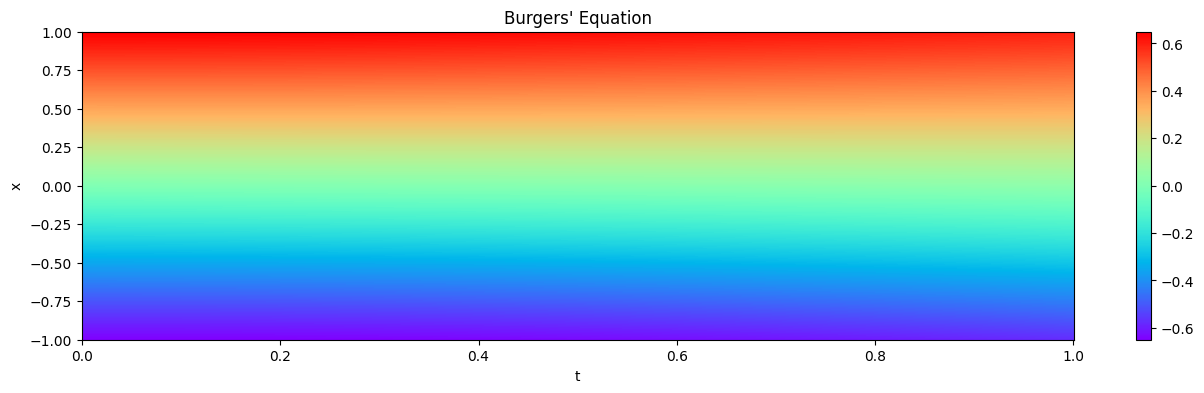

In [5]:
plotter = Burger_Plotter()
plotter(upinn.u, upinn.G)["Heatmap"].show()

In [6]:
# Function for refining collocation points based on loss

def collocation_refiner(u_hat, pde_func):
    # Use RAD algorithm to refine collocation points
    N = 1000000
    D = 1000

    x = torch.rand(N, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
    t = torch.rand(N, 1, requires_grad=True)
    z = torch.cat([t, x], dim=1)

    # Compute the residual
    u = u_hat(z)
    residual = pde_func(u, z)

    # Sample D points with the largest residual
    residual = residual.detach().numpy()
    
    return z[torch.argsort(residual, descending=True)[:D]]

## Train UPINN

In [7]:
upinn.train(
    data_points=None,
    data_target=None,
    boundary_points=boundary_points,
    collocation_points=z_f.requires_grad_(True),
    epochs=10000,
    # log_wandb=dict(name='PINN-Burgers', project='Master-Thesis', plotter=plotter, plot_interval=5),
    log_wandb=None,
    optimizer=torch.optim.Adam,
    optimizer_args=dict(lr=0.001),
    # optimizer=torch.optim.LBFGS,
    # optimizer_args=dict(lr=0.8),
    # beta_softadapt=0.1,
    # scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    # scheduler_args=dict(factor=0.9, patience=100, min_lr=1e-6),
    loss_tol=1e-5,
    lambda_reg=0.0,
    # priotize_pde=100.0,
    collocation_refiner=collocation_refiner,
    )

Beginning training...
Running on: cuda


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 57%|█████▋    | 5672/10000 [01:00<00:46, 93.52it/s, Loss=1e-5, BC Loss=1.1e-5, PDE Loss=1.8e-5, Data Loss=0, Reg Loss=0, LR_reg=0]         

Loss below tolerance at epoch 5672. Terminating training.
Training complete.


{'Heatmap': <module 'matplotlib.pyplot' from 'C:\\Users\\jonas\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>}

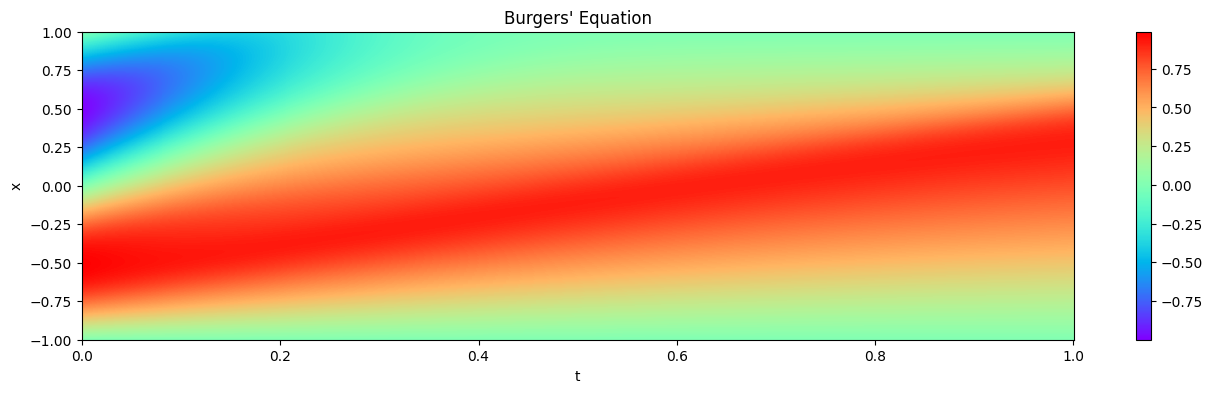

In [8]:
Burger_Plotter()(upinn.u, upinn.G)

## Improve physics loss

In [9]:
# Extend collocation points to include the entire time interval and train again
upinn.train(
    data_points=t_d.unsqueeze(-1),
    data_target=X_d,
    boundary_points=torch.tensor([[0.0]]),
    collocation_points=t[train_idx].unsqueeze(-1).requires_grad_(True),
    epochs=10000,
    log_wandb=None,
    optimizer=torch.optim.AdamW,
    optimizer_args=dict(lr=3e-4, weight_decay=1e-10),
    beta_softadapt=0.1,
    loss_tol=1e-6,
    priotize_pde=1000,
    )

NameError: name 't_d' is not defined

In [10]:
plots = plotter(upinn.u, upinn.G)
plots["Solution"].show()
plots["Missing Terms"].show()

## Train beyond the data

In [11]:
# Freeze G and parameters
G.requires_grad_(False);
bvp.requires_grad_(False);

# Extend collocation points to include the entire time interval and train again
upinn.train(
    data_points=t_d.unsqueeze(-1),
    data_target=X_d,
    boundary_points=torch.tensor([[0.0]]),
    collocation_points=t.unsqueeze(-1).requires_grad_(True),
    epochs=10000,
    log_wandb=None,
    optimizer=torch.optim.AdamW,
    optimizer_args=dict(lr=3e-4, weight_decay=1e-10),
    beta_softadapt=0.1,
    loss_tol=1e-6,
    priotize_pde=1000,
    )

Beginning training...
Running on: cpu


100%|██████████| 10000/10000 [02:12<00:00, 75.51it/s, Loss=0.0397, BC Loss=0.00265, PDE Loss=0.0858, Data Loss=0.0305, Reg Loss=0.242, LR_reg=0]

Training complete.


In [12]:
plots = plotter(upinn.u, upinn.G)
plots["Solution"].show()
plots["Missing Terms"].show()